How to run a smoothed particles Hydrodynamics simulation
====================

We will run a hydrodynamical simulation using a smoothed-particles hydrodynamics code.

For reference you can read chapter 5 of Portegies Zwart & McMillan 2018 (2018araa.book.....P). 

For this experiment, we will evolve a high-mass star to the end of it's lifetime using a Henyey stellar evolution code (this may take a while).
We subsequently convert the star to a hydrodynamical realization in particles and inject the supernova energy to the inner few SPH-particles. We further simulate the evolution of the gas-blob in time using a hydrodynamics code.

The script in this notebook is based on the work by (Rimoldi et al.)[https://ui.adsabs.harvard.edu/abs/2016ComAC...3....2R/abstract].

With this tutorial you will learn
 * Run another AMUSE module to generate initial conditions for yet another code.
 * How to recove the crash of a code and pick-up the result.
 * Store simulation data in the form if python pickel files, and recover from those.
 * plot the result of a hydrodynamical simulation.
 * make an animation of simulation results.
 * Run an AMUSE module as a parallel job.
 * Evolve a star to a certain evolutionary stage.

In [1]:
%matplotlib inline
import os
import numpy
from matplotlib import pyplot
from amuse.units import units

After loading in the most essential modules, we will setup the stellar evolution.

In [2]:
from amuse.ext.star_to_sph import (pickle_stellar_model, convert_stellar_model_to_SPH,)
from amuse.test.amusetest import get_path_to_results
from amuse.community.mesa.interface import MESA
from amuse.datamodel import Particles

def setup_stellar_evolution_model():
    out_pickle_file = os.path.join(get_path_to_results(), 
                                   "super_giant_stellar_structure.pkl")
    if os.path.exists(out_pickle_file):
        return out_pickle_file

    stellar_evolution = MESA(redirection="none")
    stars = Particles(1)
    stars.mass = 15.0 | units.MSun
    stellar_evolution.particles.add_particles(stars)
    stellar_evolution.commit_particles()

    print(
        "Evolving a MESA star with mass:",
        stellar_evolution.particles[0].mass
    )
    try:
        #while stellar_evolution.particles[0].stellar_type != (6|units.stellar_type):
        while stellar_evolution.model_time<12|units.Myr:
            stellar_evolution.evolve_model()
            print("star:", stellar_evolution.particles[0].stellar_type, stellar_evolution.model_time.in_(units.Myr))
    except AmuseException as ex:
        print("Evolved star to", stellar_evolution.particles[0].age)
        print("Radius:", stellar_evolution.particles[0].radius)
    
    pickle_stellar_model(stellar_evolution.particles[0], out_pickle_file)
    stellar_evolution.stop()
    return out_pickle_file

pickle_file = setup_stellar_evolution_model()
print("Star generated.")

Star generated.


Now the mass functions are determine, we can evolve the stars in time. for this we start two stellar evolution codes, both parametrized and evolve the stars in time.

In [3]:
number_of_sph_particles = 1000
print(pickle_file)
print("Creating initial conditions from a MESA stellar evolution model...")
model = convert_stellar_model_to_SPH(
        None,
        number_of_sph_particles,
        seed=12345,
        pickle_file=pickle_file,
        #        base_grid_options = dict(type = "glass", target_rms = 0.01),
        with_core_particle=True,
        target_core_mass = 1.4|units.MSun
    )
print("model=", model)
core, gas_without_core, core_radius = \
        model.core_particle, model.gas_particles, model.core_radius
print("Created", len(gas_without_core),
       "SPH particles and one 'core-particle':\n", core)
print("Setting gravitational smoothing to:", core_radius.in_(units.km))

/home/spz/AMUSE/amuse/test_results/super_giant_stellar_structure.pkl
Creating initial conditions from a MESA stellar evolution model...
model= StellarModelInSPH(gas_particles=<amuse.datamodel.particles.Particles object at 0x7f1671fed090>, core_particle=<amuse.datamodel.particles.Particle object at 0x7f1670e11910>, core_radius=quantity<5735590730.5 0.01 * m>)
Created 1000 SPH particles and one 'core-particle':
 Particle(13236515925435403088, set=<139734364418128>
    , mass=1.41745536512 MSun
    , radius=5735590730.5 0.01 * m
    , vx=0.0 m / s
    , vy=0.0 m / s
    , vz=0.0 m / s
    , x=0.0 m
    , y=0.0 m
    , z=0.0 m)
Setting gravitational smoothing to: 57355.907305 km


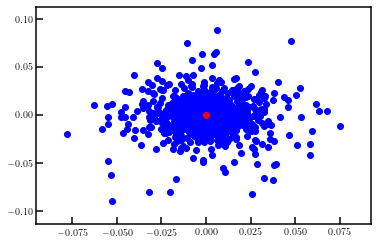

In [4]:
pyplot.scatter(gas_without_core.x.value_in(units.au), gas_without_core.y.value_in(units.au), c='b')
pyplot.scatter(core.x.value_in(units.au), core.y.value_in(units.au), c='r')
pyplot.show()

Note that the mass of the core is not precisely what you put in. 
the reason is that mass has to be preserved in the simulation, and we remove a number of SPH particles to accomodate the mass of the neutron star. It happens to be the case that the summ of the masses of these SPH particles slightly exceeds our intended 1.4 solar masses.

In [5]:
def inject_supernova_energy(gas_particles, 
                            explosion_energy=1.0e+51|units.erg,
                            exploding_region=10|units.RSun):
    inner = gas_particles.select(
        lambda pos: pos.length_squared() < exploding_region**2,
        ["position"])
    print(len(inner), "innermost particles selected.")
    print("Adding", explosion_energy / inner.total_mass(), "of supernova " \
        "(specific internal) energy to each of the n=", len(inner), "SPH particles.")
    inner.u += explosion_energy / inner.total_mass()
    
inject_supernova_energy(gas_without_core, exploding_region=1|units.RSun)

227 innermost particles selected.
Adding 1.64913762832e+20 1e-07 * m**2 * s**-2 of supernova (specific internal) energy to each of the n= 227 SPH particles.


Here we injected 10^51 erg in the inner-most SPH particles (those within 1 RSun of the stellar center). It turns out that we spread the supernova energy among 340 SPH particles. Spreading it over too few particles introduces interesting side effects, such as individual SPH particles being launched, as bullets, from the exploding star. Spreading the supernova energy over too many SPH particles, also has interesting consequences: the explosion would them drive the homologeous expansion of the entire star, rather than an explosion from the inside. 

In [6]:
def natal_kick_to_neutron_star(neutron_star, v_kick):
    neutron_star.velocity += v_kick
    return neutron_star

core = natal_kick_to_neutron_star(core, (250., 0.0, 0.0)|units.kms)

In [7]:
from amuse.community.gadget2.interface import Gadget2
from amuse.lab import nbody_system
converter = nbody_system.nbody_to_si(10|units.MSun, core_radius)

hydro_code = Gadget2(converter, number_of_workers=6)
hydro_code.parameters.epsilon_squared = core_radius**2
hydro_code.parameters.n_smooth_tol = 0.01
hydro_code.gas_particles.add_particles(gas_without_core)
hydro_code.dm_particles.add_particle(core)

We introduced and initialized the hydrodynamics solver, for which we adopted *Gadget2*. An altarnative would be to use *fi* or a grid-based hydro code.
Each hydro solver has it's advantages and disadvantages. For SPH, the smoothing length and associated tolerance are important parameters to set. Another important parameter is the artivicial viscosity parameter *alpha*. You may want to experiment with those settings, probably breaking the code on the way.

Note that we started the SPH code with 6 workers, meaning that it will use 6 cores. For some machines this will be too much, in particular because another core is used for your python notebook, and maybe you are running something in the background, like an emacs editor. However, if you have more than 8 cores, feel free to increase the number of cores on which you run the hydrodynamics code, and you will be rewarded with a shorter waiting time.

In [8]:
from amuse.datamodel import Grid

def hydro_plot(hydro_code, view_size, npixels):
    view = [-1, 1, -1, 1] * view_size
    shape = (npixels, npixels, 1)
    size = npixels**2
    axis_lengths = [0.0, 0.0, 0.0] | units.m
    axis_lengths[0] = view[1] - view[0]
    axis_lengths[1] = view[3] - view[2]
    grid = Grid.create(shape, axis_lengths)
    grid.x += view[0]
    grid.y += view[2]
    speed = grid.z.reshape(size) * (0 | 1/units.s)
    rho, rhovx, rhovy, rhovz, rhoe = hydro_code.get_hydro_state_at_point(
            grid.x.reshape(size),
            grid.y.reshape(size),
            grid.z.reshape(size), speed, speed, speed)

    # we have to make some cuts in the parameter space.
    min_v = 800.0 | units.km / units.s
    max_v = 3000.0 | units.km / units.s
    min_rho = 3.0e-9 | units.g / units.cm**3
    max_rho = 1.0e-5 | units.g / units.cm**3
    min_E = 1.0e11 | units.J / units.kg
    max_E = 1.0e13 | units.J / units.kg

    v_sqr = (rhovx**2 + rhovy**2 + rhovz**2) / rho**2
    E = rhoe / rho
    log_v = numpy.log((v_sqr / min_v**2)) / numpy.log((max_v**2 / min_v**2))
    log_rho = numpy.log((rho / min_rho)) / numpy.log((max_rho / min_rho))
    log_E = numpy.log((E / min_E)) / numpy.log((max_E / min_E))

    red = numpy.minimum(numpy.ones_like(rho.number), numpy.maximum(
        numpy.zeros_like(rho.number), log_rho)).reshape(shape)
    green = numpy.minimum(numpy.ones_like(rho.number), numpy.maximum(
        numpy.zeros_like(rho.number), log_v)).reshape(shape)
    blue = numpy.minimum(numpy.ones_like(rho.number), numpy.maximum(
        numpy.zeros_like(rho.number), log_E)).reshape(shape)
    alpha = numpy.minimum(
            numpy.ones_like(log_v),
            numpy.maximum(
                numpy.zeros_like(log_v),
                numpy.log((rho / (10*min_rho)))
                )
            ).reshape(shape)

    rgba = numpy.concatenate((red, green, blue, alpha), axis=2)

    pyplot.figure(figsize=(npixels/100.0, npixels/100.0), dpi=100)
    pyplot.imshow(rgba)

We are done setting up the experiment, and can start to run production.
In this case, we decided to run in small parts of 1 second, 1 minute, 1 hour and 1 day, to see what happens to the exploding star.

Interestingly, *Gadget2*, the hydrocode in this exercise, has a built in time limit of about 6 hours. There is no particular reason for thi limit. But then, we can easily change this, for example to 10 days.

In [9]:
hydro_code.parameters.time_max = 1.0|units.yr

Done running
Grid.create deprecated, use new_regular_grid instead
done plotting


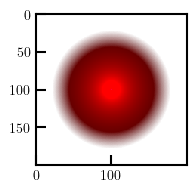

In [10]:
hydro_code.evolve_model(1.0|units.s)
print("Done running")
view_size = 350 | units.RSun
npixels = 200
hydro_plot(hydro_code, view_size, npixels)
print("done plotting")

Done running
Grid.create deprecated, use new_regular_grid instead


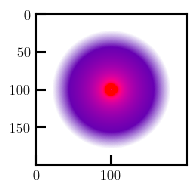

In [11]:
hydro_code.evolve_model(1.0|units.minute)
print("Done running")
hydro_plot(hydro_code, view_size, npixels)

In [12]:
print("v-core=", hydro_code.dm_particles.velocity.length().in_(units.kms))
print("d-core=", hydro_code.dm_particles.position.length().in_(units.RSun))

v-core= 236.892178481 kms
d-core= 0.0209582830397 RSun


Done running
Grid.create deprecated, use new_regular_grid instead


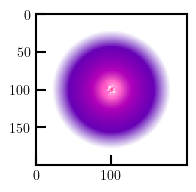

In [13]:
hydro_code.evolve_model(1.0 | units.hour)
print("Done running")
hydro_plot(hydro_code, view_size, npixels)

In [21]:
p = new_plummer_model(10)
q = new_disk_model(100)
p.name = "halo"
q.name = "disk"
all_particles = p+q
disk_particles = all_particles[all_particles.name=="disk"]

NameError: name 'new_plummer' is not defined

In [ ]:
#while hydro_code.model_time<1|units.day:
hydro_code.evolve_model(hydro_code.model_time+(1|units.hour))
print("Done running, until:", hydro_code.model_time.in_(units.s))
hydro_plot(hydro_code, view_size, npixels)

In [ ]:
print("core=", hydro_code.dm_particles.velocity.length().in_(units.kms))
print("core=", hydro_code.dm_particles.position.length().in_(units.RSun))

In [ ]:
hydro_code.stop()

You have performed a hydrodynamical explosion of a star that is experiencing a supernova. This was realized by first evolving the star to an advanced state using a 1D stellar evolution (a so-called Henyey) code. this one-dimensional structure was subsequently converted to a 3-dimensional hydrodynamical distribution of particles, representing the core and the gaseous envelope.

We injected a supernova-amount of energy into the hydrodynamical blob, heating the inner most particles to extreemely high temperatures and let the hydrodynamical code calculste the response.
The result was calculated 1 second, 1 minute, 1 hour and 1 day after the explosion.


Assignmnets and questions:
---------------

Note: the script is configured for running with 1000 SPH particles, which is too small to study the morphology of the final simulation results, 1 day after the initiation of the supernova. Try running with 10000 SPH particles, of better even would be to run with 30000 particles. However, the runs will become rather expensive. Most questions you can answer with ony 1000 SPH harticles.

Another way to speed-up the code would be by not letting the stellar evolution code run all the way util it crashes. In particular the last few steps are time consuming and do not really chage much to that part of the star in which we are most interested (the density gradient between the core-region and the envrlope. This part is already converged to it's final density profile once the star ascends the second asymptotic giant branch. You can shorten runtime considerably by allowing the star to evolve to that point in it's evolution.

### Question 1:
Where is the stellar model saved, once produced?
What is the age and radius of the star at the moment is starts to ascend the first giant branch?

### Assignment 1:
Each time we run the script a new star is evolved until the stellar-evolution code crashes. These runs are rather expensive, and as so long as we do not change the mass of the star we repeat the same calculation each time we restart the script. This is rather wasteful for computer cycles, and for the environment. 
You can use the internal amuse routine *get_path_to_results* to store the picke file in your local amuse repository in $AMUSE_DIR/test_results.

Add the necessary lines to the *setup_stellar_evolution_model* script in which the star is evolved to picke the result of the stellar evolution calculation if a new calculation is performed. But first check if the desired pickled star already exist, in which case you should not redo the simulation. 

In addition, change the scipt in which the star is evolve to let it run until the star has reached the asymptotic giant branch.

### Question 1:
In the routine *inject_supernova_energy* we use a *lambda* function. Explain what this function does.

### Question 2:
In the three images, after running for 1 second, 1 minute and 1 hour, the star only seem to change color in the images. Explain why this is.

### Assigment 2:
In the routing *plot_hydro* we assign various parameters to the colors red, green and blue, and to the transparancy alpha. Explain what these parameters main, and how this translates to the various colors you observed in the plotted pictures.

### Assignment 3:
Rerun the calculation but plot the kinetic energy, the potential energy and the total energy of the gas as a function of time from the start of the supernova to 2 days after the supernova. Describe the furves and explain what is happening.

### Questions 3:
check the velocity of the neutron star at the end of the simulation.
It is not zero, as it was initially. Why is this the case?

### Assignment 4:
Usually neutron stars are believed to recieve rather high "natal" kicks upon birth. We still do not really understand why. In our simulations, we can introduce such a kick velocity by hand. A reasonable kick for a neutron star could be about 250km/s.
Impose such a high velocity kick to the newly born neutron star at the moment of the actual explosion and rerung the simulation.

### Question 4:
What effect that the high natal velocity kick of the neutron star has on the morphology and energy budget of the hydrodynamical outflow of the supernova shell?

### Assignment 5:
Add the appropriate lines to the plotting routine to write the images to files.
Rerun the code, and make an animation of the exploding star.